In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.robust import mad
from numpy.random import normal

# Include the utils functions
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

# For the pre-detection of vortices calculations
num_sig = 5.

min_b_over_Dact = 0.2
max_b_over_Dact = 3.
num_Vobs_sig = 3.

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

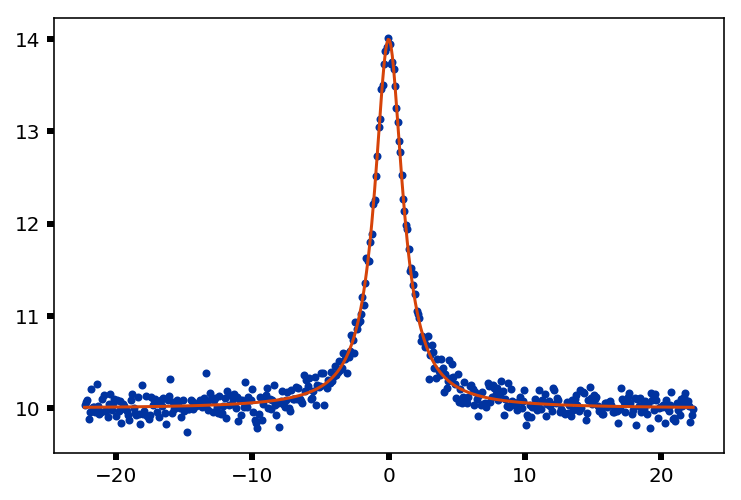

In [45]:
t0 = 0.
sampling=0.1
time_offset = normal(scale=sampling/2.)

Pact = 5. # Pa
Dact = 10. # m
density = 0.2 # kg/m^3
Vact = np.sqrt(Pact/density) # cyclostrophic balance

wind_sigma = 0.1 # m/s noise

U1 = 10.
U2 = 10.

bs = Dact
Dobs = np.sqrt(Dact**2 + (2.*bs)**2)
Gamma_obs = Dobs/U1
Vobs = (2.*Vact*(2.*bs/Dact)/(1. + (2.*bs/Dact)**2))
Pobs = Pact/(1. + (2.*bs/Dact)**2)

t = np.arange(-10.*Gamma_obs, 10.*Gamma_obs, sampling) + time_offset

# U1 and U2 set equal!
profile = wind_profile(t, t0, Vobs, U1, U1, bs, Gamma_obs)
noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

plt.scatter(t, noisy_profile, marker='.', color=BoiseState_blue)
plt.plot(t, profile, color=BoiseState_orange)

[ 3.78638764 10.00546048  9.89233019  6.6349549 ] [0.3387594  0.07604455 0.07589561 2.39858692]
4.0 10.0 10.0 10.0
3.5315294560772688 4.202100341541875 11.898811531390878 9.465969101740713
5.0 5.0 10.0 10.0


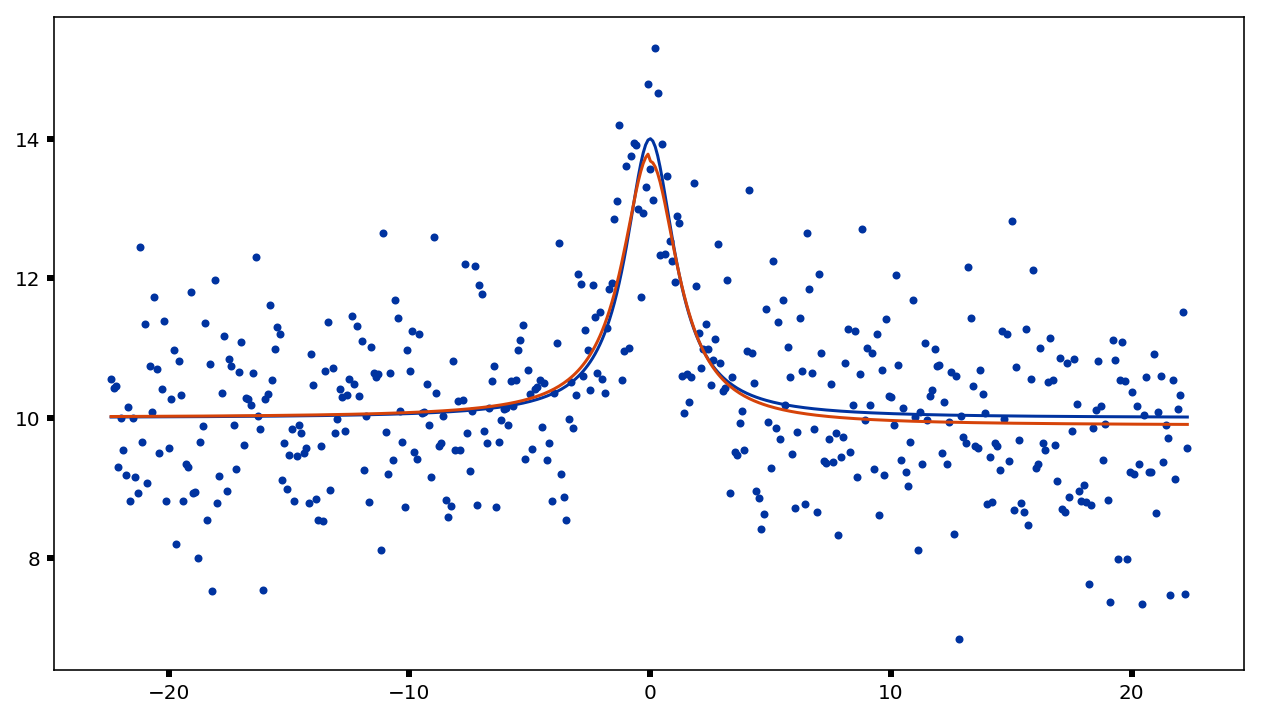

In [17]:
profile = wind_profile(t, t0, Vobs, U1, U2, bs, Gamma_obs)
noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)

ax1.plot(t, wind_profile(t, t0, Vobs, U1, U1, bs, Gamma_obs), color=BoiseState_blue)

popt, uncertainties = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs, 
                                       [np.sign(Vobs)*1., 1., 1., np.sign(bs)*1.])        
print(popt, uncertainties)
print(Vobs, U1, U2, bs)
fit_Pact, fit_Vact, fit_Dact, fit_bact = calculate_act_values(density, popt[0], Pobs, Dobs)
print(fit_Pact, fit_Vact, fit_Dact, fit_bact)
print(Pact, Vact, Dact, bs)

ax1.scatter(t, noisy_profile, color=BoiseState_blue, marker='.')
ax1.plot(t, wind_profile(t, t0, popt[0], popt[1], popt[2], popt[3], Gamma_obs), color=BoiseState_orange)

(-2, 2)

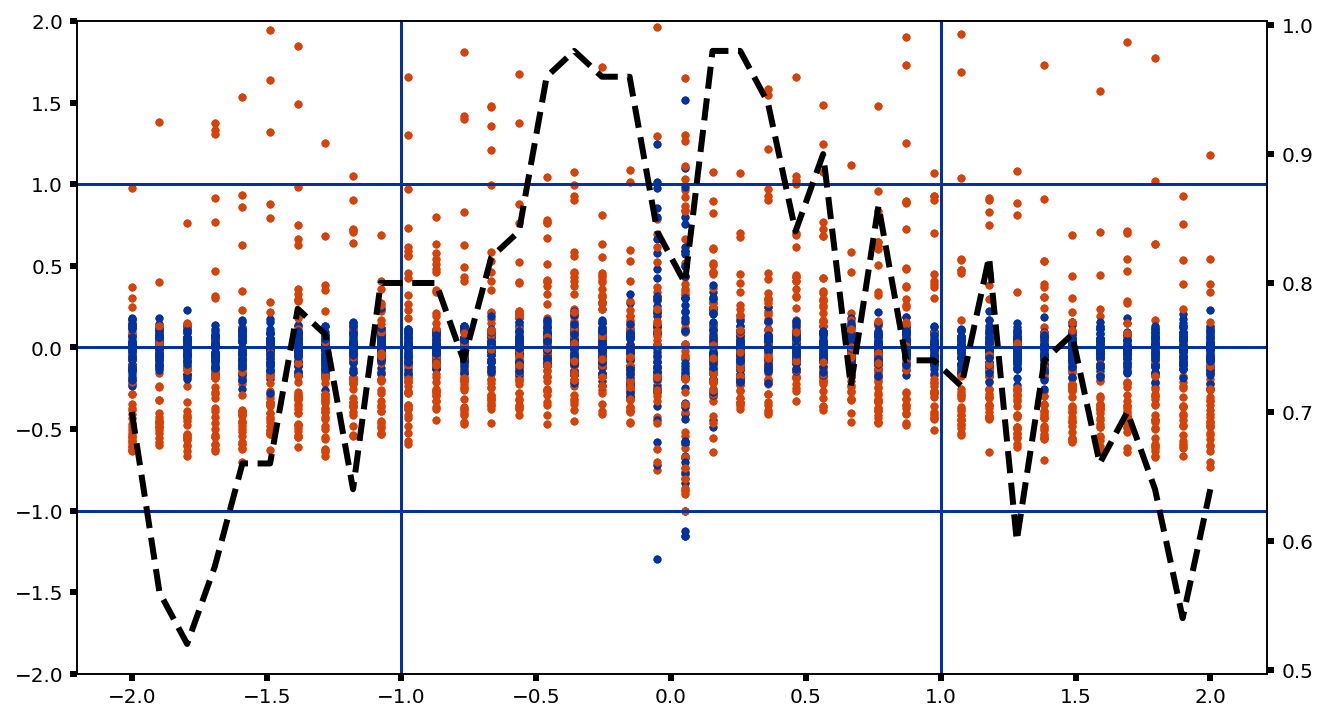

In [75]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

wind_sigma = 1. # m/s noise

num_bs = 40
num_tries = 50
bs = np.linspace(-2.*Dact, 2.*Dact, num_bs)

num_wrongs = np.zeros_like(bs)

for i in range(len(bs)):
    for j in range(num_tries):
    
        Dobs = np.sqrt(Dact**2 + (2.*bs[i])**2)
        Gamma_obs = Dobs/U1
        Vobs = np.abs((2.*Vact*(2.*bs[i]/Dact)/(1. + (2.*bs[i]/Dact)**2)))
        Pobs = Pact/(1. + (2.*bs[i]/Dact)**2)

        profile = wind_profile(t, t0, Vobs, U1, U2, bs[i], Gamma_obs)
        noisy_profile = profile + normal(scale=wind_sigma, size=len(t))

        try:
            popt, uncertainties = fit_wind_profile(t, noisy_profile, wind_sigma, 0., Gamma_obs, 
                                                   [np.sign(Vobs)*1., 1., 1., np.sign(bs[i])*1.])

            if((np.abs((popt[0] - Vobs)/Vobs) > 1) or ((np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]) > 1)):
    #             print(i, bs[i]/Dact, (popt[0] - Vobs)/Vobs, popt[0], Vobs)

                num_wrongs[i] += 1

    #         if((np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]) > 2):
    #             print(bs[i]/Dact, (np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]), popt[3], bs[i])

            # Vobs
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], [(popt[0] - Vobs)/Vobs, (popt[0] - Vobs)/Vobs], 
                       marker='.', color=BoiseState_blue)
            # bs
            ax1.scatter([bs[i]/Dact, bs[i]/Dact], 
                        [(np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i]), 
                         (np.abs(popt[3]) - np.abs(bs[i]))/np.abs(bs[i])], 
                       marker='.', color=BoiseState_orange)        

        except:
            print("%g didn't work!" % (bs[i]/Dact))

ax2.plot(bs/Dact, 1. - num_wrongs/num_tries, color='k', lw=3, ls='--')
            
ax1.axhline(-1, color=BoiseState_blue)
ax1.axhline(1, color=BoiseState_blue)
ax1.axvline(-1, color=BoiseState_blue)
ax1.axvline(1, color=BoiseState_blue)
ax1.axhline(0., color=BoiseState_blue)
ax1.set_ylim([-2, 2])